In [ ]:
# IMPORTS & DEFINITIONS

import csv, sys
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np; np.set_printoptions(threshold=sys.maxsize)
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import math
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler

DUD_VALUE= 0 # change from 0 to something like 123 for debugging
EMPTY_DATA_DAY_VAL= 123456789
TOTAL_ROWS= 999999999
INPUT_ROWS_LIMIT= TOTAL_ROWS # 500000
FILENAME= 'dublinbikes_2020_Q1.csv'
MAX_STATIONS= 118
SECS_IN_5MIN= 300
DATAPOINT_EVERYX_MIN= 5
DATAPOINTS_PER_DAY= 288
DAYS_OF_WEEK= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # yes, I consider Monday to be the '0'/start of the week
STARTING_DATE= 0 # aka Monday. Because the 27th of Jan 2020 is a Monday
MISSING_STATIONS= [117, 116, 70, 60, 46, 35, 20, 14, 1, 0]
NUM_STATIONS= MAX_STATIONS - len(MISSING_STATIONS)
SUBSTANDARD_DAYS= [] # [50, 49]
TOTAL_DAYS= 66 # from 27 / 1 / 2020 to (and including) 1 / 4 / 2020
HOURS= 24
EPOCH= datetime.datetime(2020, 1, 27, 0, 0)
TOTAL_TIME_DATAPOINTS= int((datetime.datetime(2020,4,2,0,0) - EPOCH).total_seconds() / SECS_IN_5MIN)
K= 5
STEP_SIZE= 0.02185 # just the magic number that leads to 288 values being generated
R= 0.5
MAX_HINDSIGHT= 60 # minutes
DAYS_PER_WEEKDAY= 5
HOMEMADE_REGULISER= 0.8

class DataDay: # ideally this would be nested in the Station class
    def __init__(self, index):
        self.index= index
        self.substandard_day= False
        if index in SUBSTANDARD_DAYS:
            self.substandard_day= True
        self.times_populated= 0
        self.day_of_week= ((STARTING_DATE + index) % len(DAYS_OF_WEEK))
        
        self.daily_epoch_time= np.full(DATAPOINTS_PER_DAY, EMPTY_DATA_DAY_VAL, dtype=np.int)
        self.epoch_time= np.full(DATAPOINTS_PER_DAY, EMPTY_DATA_DAY_VAL, dtype=np.int)
        self.bikes= np.full(DATAPOINTS_PER_DAY, EMPTY_DATA_DAY_VAL, dtype=np.int)
        self.percent_bikes= np.full(DATAPOINTS_PER_DAY, float(EMPTY_DATA_DAY_VAL), dtype=np.float)

    def populate(self, daily_epoch_time, epoch_time, bikes, percent_bikes):
        if self.substandard_day == False:
            self.daily_epoch_time[daily_epoch_time]= daily_epoch_time
            self.epoch_time[daily_epoch_time]= epoch_time
            self.bikes[daily_epoch_time]= bikes
            self.percent_bikes[daily_epoch_time]= percent_bikes
            self.times_populated+= 1

class Station:
    def __init__(self, index):
        self.index= index
        self.name= DUD_VALUE
        self.bike_capacity= DUD_VALUE
        self.address= DUD_VALUE
        self.latitude= DUD_VALUE
        self.longitude= DUD_VALUE
        self.data_days= [DataDay(i) for i in range(0, TOTAL_DAYS)]
    
    def populate_consts(self, name, bike_capacity, address, latitude, longitude):
        self.name= name
        self.bike_capacity= bike_capacity
        self.address= address
        self.latitude= latitude
        self.longitude= longitude

def get_station_id(name):
    try:
        index= [x.name for x in stations].index(name)
    except ValueError:
        index= -1
    return index

In [ ]:
# DATA STRUCTURING

total_capacity= 0 # not in use currently
index= []; daily_epoch_time= []; epoch_time= []; percent_bikes= [];
stations= [Station(i) for i in range(0, MAX_STATIONS)]
indices_to_populate= list(range(0, MAX_STATIONS))
for index in MISSING_STATIONS:
    indices_to_populate.remove(index)

with open(FILENAME, newline='') as f:
    reader = csv.reader(f); next(reader) # skip data header
    current_index= 0
    try:
        while len(indices_to_populate) != 0:
            row= next(reader)
            if int(row[0]) == current_index: # this clause is just for performance
                continue
            current_index= int(row[0])
            if current_index in indices_to_populate:
                stations[current_index].populate_consts(row[3], row[4], row[8], row[9], row[10])
                indices_to_populate.remove(current_index)
                total_capacity+= int(row[4])
        
        f.seek(0)
        reader= csv.reader(f); row= next(reader) # skip data header
        for row_i, row in enumerate(reader):
            if row_i >= INPUT_ROWS_LIMIT:
                break
            if int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - EPOCH).total_seconds()) < 0:
                continue
            try:
                epoch_time= int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - EPOCH).total_seconds() / SECS_IN_5MIN)
                stations[int(row[0])].data_days[int(epoch_time / DATAPOINTS_PER_DAY)].populate( \
                    int((datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), int(row[1][11: 13]), int(row[1][14: 16])) - datetime.datetime(int(row[1][0:4]), int(row[1][5:7]), int(row[1][8:10]), 0, 0)).total_seconds() / (SECS_IN_5MIN)), \
                    epoch_time, \
                    int(row[6]), \
                    float("{:.3f}".format(float(row[6]) / float(row[4]))))
            except IndexError as e:
                print("Error:", e, int(row[0]))
                #print("\nTRIED: ", epoch_time, ' / ', DATAPOINTS_PER_DAY, ' = ', int(epoch_time / DATAPOINTS_PER_DAY))
                #print(row[1])
    except csv.Error as e:
        sys.exit('file {}, line {}: {}'.format(filename, reader.line_num, e))
            
for station_i, station in enumerate(stations):
    last_bikes= 0
    last_percent_bikes= 0
    for day_i, data_day in enumerate(station.data_days):
        for val_i, val in enumerate(data_day.bikes):
            if val == EMPTY_DATA_DAY_VAL:
                stations[station_i].data_days[day_i].populate(val_i, day_i * DATAPOINTS_PER_DAY + val_i, last_bikes, last_percent_bikes)
            else:
                last_bikes= data_day.bikes[val_i]
                last_percent_bikes= data_day.percent_bikes[val_i]

In [ ]:
# FEATURE DATA PREPERATION

fullness_in10= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.int)
fullness_in30= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.int)
fullness_in60= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.int)
fullness= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.int)

fullness_percent= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.float)
bikes_changes_pastx= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS, int(MAX_HINDSIGHT / DATAPOINT_EVERYX_MIN)), DUD_VALUE, dtype=np.int)
days_of_week= np.full((TOTAL_TIME_DATAPOINTS, len(DAYS_OF_WEEK)), DUD_VALUE, dtype=np.int)
hour_of_day= np.full((TOTAL_TIME_DATAPOINTS, HOURS), DUD_VALUE, dtype=np.float)
average_weekday_fullness= np.full((DATAPOINTS_PER_DAY, NUM_STATIONS, len(DAYS_OF_WEEK)), DUD_VALUE, dtype=np.float)
weekdays_vol= np.full((NUM_STATIONS, len(DAYS_OF_WEEK)), 0, dtype=np.float)
avrg_weekday_full= np.full((NUM_STATIONS, len(DAYS_OF_WEEK)), 0, dtype=np.float)
meanmean= np.full(NUM_STATIONS, 0, dtype=np.float)

scld_fullness_percent= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.float)
scld_bikes_changes_pastx= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS, int(MAX_HINDSIGHT / DATAPOINT_EVERYX_MIN)), 0, dtype=np.float)
scld_days_of_week= np.full((TOTAL_TIME_DATAPOINTS, len(DAYS_OF_WEEK)), DUD_VALUE, dtype=np.int)
scld_hour_of_week= np.full((TOTAL_TIME_DATAPOINTS, HOURS), DUD_VALUE, dtype=np.float)

station_index_decrement= 0 # this is a varying offset for the indexing of stations that accounts for missing stations that are being ignored
for epoch_day_i in range(TOTAL_DAYS):
    #print("########### epoch_day_i: ", epoch_day_i)
    x_offset= epoch_day_i * DATAPOINTS_PER_DAY
    y_offset= 0
    
    block= np.zeros((DATAPOINTS_PER_DAY, HOURS), dtype=np.float)
    daily_epoch_time= list(range(DATAPOINTS_PER_DAY))
    for time_i in daily_epoch_time:
        hour= float("{:.3f}".format(time_i / 12)) # divide by 12 because there are 12 datapoints in an hour
        block[time_i][(int(hour) + 1) % HOURS]= hour % 1
        block[time_i][int(hour)]= 1 - (hour % 1)
    hour_of_day[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
    
    day_of_week= stations[2].data_days[epoch_day_i].day_of_week
    block= np.zeros((DATAPOINTS_PER_DAY, len(DAYS_OF_WEEK)), dtype=np.int)
    for block_i, sub_arr in enumerate(block):
        block[block_i][day_of_week]= 1
    days_of_week[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
    
    for station in stations:
        #print("###### station.index: ", station.index)
        if station.index == 0:
            station_index_decrement= 0
        if station.index in MISSING_STATIONS:
            station_index_decrement+= 1
            continue
        y_offset= station.index - station_index_decrement
        
        block= station.data_days[epoch_day_i].percent_bikes
        block= np.reshape(block, (DATAPOINTS_PER_DAY, 1))
        fullness_percent[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
        
        block= station.data_days[epoch_day_i].bikes
        block= np.reshape(block, (DATAPOINTS_PER_DAY, 1))
        fullness[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
        block= np.reshape(block, (DATAPOINTS_PER_DAY, 1, 1))
        if weekdays_vol[y_offset, day_of_week] < DAYS_PER_WEEKDAY:
            average_weekday_fullness[0:DATAPOINTS_PER_DAY, y_offset:y_offset + block.shape[1], day_of_week:day_of_week+1]+= block
            weekdays_vol[y_offset:y_offset+1, day_of_week:day_of_week+1]+= 1
        
        bikes= station.data_days[epoch_day_i].bikes
        block= np.reshape(bikes[2:], (bikes.shape[0] - 2, 1))
        fullness_in10[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
        block= np.reshape(bikes[6:], (bikes.shape[0] - 6, 1))
        fullness_in30[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
        block= np.reshape(bikes[12:], (bikes.shape[0] - 12, 1))
        fullness_in60[x_offset:x_offset + block.shape[0], y_offset:y_offset + block.shape[1]]= block
        
        block= np.reshape(station.data_days[epoch_day_i].bikes, (DATAPOINTS_PER_DAY, 1))
        if epoch_day_i - 1 == -1:
            prev_block= np.zeros((DATAPOINTS_PER_DAY, 1), dtype=np.int)
        else:
            prev_block= np.reshape(station.data_days[epoch_day_i - 1].bikes, (DATAPOINTS_PER_DAY, 1))
        block_xminchange= np.zeros((DATAPOINTS_PER_DAY, int(MAX_HINDSIGHT / DATAPOINT_EVERYX_MIN)), dtype=np.int)
        fullness_xago= np.zeros((DATAPOINTS_PER_DAY, int(MAX_HINDSIGHT / DATAPOINT_EVERYX_MIN)), dtype=np.int)
        for col_i in range(fullness_xago.shape[1]):
            i= col_i + 1
            fullness_xago[i:DATAPOINTS_PER_DAY, col_i:col_i + 1]= block[0:DATAPOINTS_PER_DAY - i, 0:1]
            fullness_xago[0:i, col_i:col_i + 1]= prev_block[DATAPOINTS_PER_DAY - i:DATAPOINTS_PER_DAY, 0:1]
        for col_i in range(fullness_xago.shape[1]):
            block_xminchange[0:DATAPOINTS_PER_DAY, col_i:col_i + 1]= np.subtract(block, fullness_xago[0:DATAPOINTS_PER_DAY, col_i:col_i + 1])
        
        bikes_changes_pastx[x_offset:x_offset + block_xminchange.shape[0], y_offset:y_offset + 1, 0:block_xminchange.shape[1]]= np.reshape(block_xminchange, (DATAPOINTS_PER_DAY, 1, block_xminchange.shape[1]))

station_index_decrement= 0 # this is a varying offset for the indexing of stations that accounts for missing stations that are being ignored
for station in stations:
    if station.index == 0: # [117, 116, 70, 60, 46, 35, 20, 14, 1, 0]
        station_index_decrement= 0
    if station.index in MISSING_STATIONS:
        station_index_decrement+= 1
        continue
    y_offset= station.index - station_index_decrement
    for day_of_week_i in range(len(DAYS_OF_WEEK)):
        average_weekday_fullness[0:DATAPOINTS_PER_DAY, y_offset:y_offset+1, day_of_week_i:day_of_week_i+1]/= weekdays_vol[y_offset:y_offset+1, day_of_week_i:day_of_week_i+1]
        avrg_weekday_full[y_offset:y_offset+1, day_of_week_i:day_of_week_i+1]= np.mean(average_weekday_fullness[0:DATAPOINTS_PER_DAY, y_offset:y_offset+1, day_of_week_i:day_of_week_i+1])
    meanmean[y_offset:y_offset+1]= np.mean(avrg_weekday_full[y_offset:y_offset+1])

# scld_fullness_percent= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS), DUD_VALUE, dtype=np.float)
# scld_bikes_changes_pastx= np.full((TOTAL_TIME_DATAPOINTS, NUM_STATIONS, int(MAX_HINDSIGHT / DATAPOINT_EVERYX_MIN)), 0, dtype=np.float)
# scld_hour_of_week= np.full((TOTAL_TIME_DATAPOINTS, HOURS), DUD_VALUE, dtype=np.float)

###########################################
for station_i in range(bikes_changes_pastx.shape[1]):
    print("################### STATION")
    station_fullness= np.reshape(fullness_percent[0:TOTAL_TIME_DATAPOINTS, station_i:station_i+1], TOTAL_TIME_DATAPOINTS)
    one_column= station_fullness.reshape(-1, 1)
    scaler= MinMaxScaler((0, 1)).fit(one_column)
    one_column= scaler.transform(one_column)
    station_fullness= np.reshape(one_column, (station_fullness.shape[0], 1))
    scld_fullness_percent[0:TOTAL_TIME_DATAPOINTS, station_i:station_i+1]= station_fullness
    
    station_pastx= np.reshape(bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, station_i:station_i+1, 0:bikes_changes_pastx.shape[2]], (TOTAL_TIME_DATAPOINTS, bikes_changes_pastx.shape[2]))
    one_column= station_pastx.reshape(-1, 1)
    scaler= MinMaxScaler((-1, 1)).fit(one_column)
    one_column= scaler.transform(one_column)
    station_pastx= np.reshape(one_column, (station_pastx.shape[0], 1, station_pastx.shape[1]))
    scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, station_i:station_i+1, 0:bikes_changes_pastx.shape[2]]= station_pastx

In [19]:
# APPROACH DEFINITIONS
    
def run_approach1(station_name):
    index= get_station_id(station_name)
    
    y= np.full((TOTAL_TIME_DATAPOINTS, 3), 0, dtype=np.int) # change the 3 to a 6 to do both stations at once on the generalised-training form of an approach
    y[0:TOTAL_TIME_DATAPOINTS, 0:1]= np.reshape(fullness_in10[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 1:2]= np.reshape(fullness_in30[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 2:3]= np.reshape(fullness_in60[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    
    X= np.full((TOTAL_TIME_DATAPOINTS, hour_of_day.shape[1] + days_of_week.shape[1] + 3 \
                + 0 * NUM_STATIONS \
               ), 0, dtype=np.float)
    X[0:TOTAL_TIME_DATAPOINTS, 0:7]= day_of_week
    X[0:TOTAL_TIME_DATAPOINTS, 7:31]= hour_of_day
    X[0:TOTAL_TIME_DATAPOINTS, 31:32]= scld_fullness_percent[0:TOTAL_TIME_DATAPOINTS, index:index + 1]
    X[0:TOTAL_TIME_DATAPOINTS, 32:33]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index + 1, 0:1]), (TOTAL_TIME_DATAPOINTS, 1)) # past5
    X[0:TOTAL_TIME_DATAPOINTS, 33:34]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index + 1, 1:2]), (TOTAL_TIME_DATAPOINTS, 1)) # past10
    
    kf= KFold(n_splits= K)
    kf.get_n_splits(X)
    score_sum= 0.0
    i= 1
    returns= []
    for train_index, test_index in kf.split(X):
        X_train, X_test= X[train_index], X[test_index]
        y_train, y_test= y[train_index], y[test_index]
        regr= MLPRegressor(random_state= 1, max_iter= 1000, alpha=0.001).fit(X_train, y_train)
        y_pred= regr.predict(X_test)
        score_sum+= regr.score(X_test, y_test)
        returns.append(regr.score(X_test, y_test))
        #print("R**2 score of data split", i, ": ", regr.score(X_test, y_test))
        i+= 1
    #print("\nAVERAGE R**2 score: ", score_sum / K)
    return returns

def run_approach1v2(station_name):
    index= get_station_id(station_name)
    
    y= np.full((TOTAL_TIME_DATAPOINTS, 3), 0, dtype=np.int) # change the 3 to a 6 to do both stations at once on the generalised-training form of an approach
    y[0:TOTAL_TIME_DATAPOINTS, 0:1]= np.reshape(fullness_in10[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 1:2]= np.reshape(fullness_in30[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 2:3]= np.reshape(fullness_in60[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    
    X= np.full((TOTAL_TIME_DATAPOINTS, hour_of_day.shape[1] + days_of_week.shape[1] + 6 \
                + 0 * NUM_STATIONS \
               ), 0, dtype=np.float)
    X[0:TOTAL_TIME_DATAPOINTS, 0:7]= day_of_week
    X[0:TOTAL_TIME_DATAPOINTS, 7:31]= hour_of_day
    X[0:TOTAL_TIME_DATAPOINTS, 31:32]= scld_fullness_percent[0:TOTAL_TIME_DATAPOINTS, index:index + 1]
    X[0:TOTAL_TIME_DATAPOINTS, 32:33]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 0:1]), (TOTAL_TIME_DATAPOINTS, 1)) # past5
    X[0:TOTAL_TIME_DATAPOINTS, 33:34]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 1:2]), (TOTAL_TIME_DATAPOINTS, 1)) # past10
    X[0:TOTAL_TIME_DATAPOINTS, 34:35]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 2:3]), (TOTAL_TIME_DATAPOINTS, 1)) # past15
    X[0:TOTAL_TIME_DATAPOINTS, 35:36]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 3:4]), (TOTAL_TIME_DATAPOINTS, 1)) # past20
    X[0:TOTAL_TIME_DATAPOINTS, 36:37]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 4:5]), (TOTAL_TIME_DATAPOINTS, 1)) # past25

    kf= KFold(n_splits= K)
    kf.get_n_splits(X)
    score_sum= 0.0
    i= 1
    returns= []
    for train_index, test_index in kf.split(X):
        X_train, X_test= X[train_index], X[test_index]
        y_train, y_test= y[train_index], y[test_index]
        regr= MLPRegressor(random_state= 1, max_iter= 1000, alpha=0.001).fit(X_train, y_train)
        y_pred= regr.predict(X_test)
        score_sum+= regr.score(X_test, y_test)
        returns.append(regr.score(X_test, y_test))
        #print("R**2 score of data split", i, ": ", regr.score(X_test, y_test))
        i+= 1
    #print("\nAVERAGE R**2 score: ", score_sum / K)
    return returns

def run_approach1v3(station_name):
    index= get_station_id(station_name)
    
    y= np.full((TOTAL_TIME_DATAPOINTS, 3), 0, dtype=np.int) # change the 3 to a 6 to do both stations at once on the generalised-training form of an approach
    y[0:TOTAL_TIME_DATAPOINTS, 0:1]= np.reshape(fullness_in10[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 1:2]= np.reshape(fullness_in30[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 2:3]= np.reshape(fullness_in60[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    
    X= np.full((TOTAL_TIME_DATAPOINTS, hour_of_day.shape[1] + days_of_week.shape[1] + 2 \
                + 4 * NUM_STATIONS \
               ), 0, dtype=np.float)
    X[0:TOTAL_TIME_DATAPOINTS, 0:7]= day_of_week
    X[0:TOTAL_TIME_DATAPOINTS, 7:31]= hour_of_day
    X[0:TOTAL_TIME_DATAPOINTS, 31:32]= scld_fullness_percent[0:TOTAL_TIME_DATAPOINTS, index:index + 1]
    X[0:TOTAL_TIME_DATAPOINTS, 32:33]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index + 1, 0:1]), (TOTAL_TIME_DATAPOINTS, 1)) # past5
    X[0:TOTAL_TIME_DATAPOINTS, 33:141]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, 0:NUM_STATIONS, 1:2]), (TOTAL_TIME_DATAPOINTS, NUM_STATIONS)) # past10
    X[0:TOTAL_TIME_DATAPOINTS, 141:249]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, 0:NUM_STATIONS, 2:3]), (TOTAL_TIME_DATAPOINTS, NUM_STATIONS)) # past15
    X[0:TOTAL_TIME_DATAPOINTS, 249:357]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, 0:NUM_STATIONS, 3:4]), (TOTAL_TIME_DATAPOINTS, NUM_STATIONS)) # past20
    X[0:TOTAL_TIME_DATAPOINTS, 357:465]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, 0:NUM_STATIONS, 4:5]), (TOTAL_TIME_DATAPOINTS, NUM_STATIONS)) # past25

    kf= KFold(n_splits= K)
    kf.get_n_splits(X)
    score_sum= 0.0
    i= 1
    returns= []
    for train_index, test_index in kf.split(X):
        X_train, X_test= X[train_index], X[test_index]
        y_train, y_test= y[train_index], y[test_index]
        regr= MLPRegressor(random_state= 1, max_iter= 1000, alpha=0.001).fit(X_train, y_train)
        y_pred= regr.predict(X_test)
        score_sum+= regr.score(X_test, y_test)
        returns.append(regr.score(X_test, y_test))
        #print("R**2 score of data split", i, ": ", regr.score(X_test, y_test))
        i+= 1
    #print("\nAVERAGE R**2 score: ", score_sum / K)
    return returns
    
def run_approach2(station_name):
    index= get_station_id(station_name)
    
    y= np.full((TOTAL_TIME_DATAPOINTS, 3), 0, dtype=np.int) # change the 3 to a 6 to do both stations at once on the generalised-training form of an approach
    y[0:TOTAL_TIME_DATAPOINTS, 0:1]= np.reshape(fullness_in10[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 1:2]= np.reshape(fullness_in30[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    y[0:TOTAL_TIME_DATAPOINTS, 2:3]= np.reshape(fullness_in60[:,index], (TOTAL_TIME_DATAPOINTS, 1))
    
    X= np.full((TOTAL_TIME_DATAPOINTS, 2 + 3 \
            #* bikes_changes_pastx.shape[1] \ # This line is uncommented when training on all stations
           ), -1, dtype=np.float)
    
    positions= []; t= 0
    while t < 2 * math.pi:
        positions.append((1 - (R * math.cos(t) + R), R * math.sin(t) + R))
        t+= STEP_SIZE
    pos_i= 0
    for time_i in range(TOTAL_TIME_DATAPOINTS):
        X[time_i, 0]= positions[pos_i][0]
        X[time_i, 1]= positions[pos_i][1]
        pos_i= (pos_i + 1) % len(positions)
    
    X[0:TOTAL_TIME_DATAPOINTS, 2:3]= scld_fullness_percent[0:TOTAL_TIME_DATAPOINTS, index:index+1]
    X[0:TOTAL_TIME_DATAPOINTS, 3:4]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 0:1]), (TOTAL_TIME_DATAPOINTS, 1)) # past5
    X[0:TOTAL_TIME_DATAPOINTS, 4:5]= np.reshape((scld_bikes_changes_pastx[0:TOTAL_TIME_DATAPOINTS, index:index+1, 1:2]), (TOTAL_TIME_DATAPOINTS, 1)) # past5
    # X[0:TOTAL_TIME_DATAPOINTS, 2:110]= bikes_changes_past5
    # X[0:TOTAL_TIME_DATAPOINTS, 110:218]= bikes_changes_past15
    
    neigh= KNeighborsRegressor(n_neighbors= 30, weights='distance')
    cv_scores= cross_val_score(neigh, X, y, cv=5)
    #print(cv_scores) # print each cv score (accuracy) and average them
    #print('cv_scores mean:{}'.format(np.mean(cv_scores)))
    return cv_scores.tolist()

def run_oldbaseline(station_name, regulariser_coef):
    index= get_station_id(station_name)
    max_train_time= DATAPOINTS_PER_DAY * DAYS_PER_WEEKDAY * len(DAYS_OF_WEEK)
    y_test= np.reshape(fullness[max_train_time:TOTAL_TIME_DATAPOINTS, index:index+1], TOTAL_TIME_DATAPOINTS - max_train_time)
    y_pred= np.zeros(TOTAL_TIME_DATAPOINTS - max_train_time)
    for i in range(int((TOTAL_TIME_DATAPOINTS - max_train_time) / DATAPOINTS_PER_DAY)):
        datapoint_i= i * DATAPOINTS_PER_DAY
        day_of_week_i= int((max_train_time + datapoint_i) / DATAPOINTS_PER_DAY) % len(DAYS_OF_WEEK)
        y_pred[datapoint_i:datapoint_i + DATAPOINTS_PER_DAY]= (np.reshape(average_weekday_fullness[0:DATAPOINTS_PER_DAY, index:index+1, day_of_week_i:day_of_week_i+1], DATAPOINTS_PER_DAY) * (1 - regulariser_coef) + np.full(DATAPOINTS_PER_DAY, avrg_weekday_full[index:index+1, day_of_week_i:day_of_week_i+1]) * regulariser_coef)
    #print("R**2 score: ", r2_score(y_test, y_pred))
    return r2_score(y_test, y_pred)

def run_meanline(station_name):
    index= get_station_id(station_name)
    max_train_time= DATAPOINTS_PER_DAY * DAYS_PER_WEEKDAY * len(DAYS_OF_WEEK)
    y_test= np.reshape(fullness[max_train_time:TOTAL_TIME_DATAPOINTS, index:index+1], TOTAL_TIME_DATAPOINTS - max_train_time)
    y_pred= np.zeros(TOTAL_TIME_DATAPOINTS - max_train_time)
    for i in range(int((TOTAL_TIME_DATAPOINTS - max_train_time) / DATAPOINTS_PER_DAY)):
        datapoint_i= i * DATAPOINTS_PER_DAY
        day_of_week_i= int((max_train_time + datapoint_i) / DATAPOINTS_PER_DAY) % len(DAYS_OF_WEEK)
        y_pred[datapoint_i:datapoint_i + DATAPOINTS_PER_DAY]= np.full(DATAPOINTS_PER_DAY, meanmean[index:index+1], dtype=np.float64)
    #print("R**2 score: ", r2_score(y_test, y_pred))
    return r2_score(y_test, y_pred)

In [24]:
def baseline_graph():
    meanmean1= run_meanline("PORTOBELLO ROAD")
    meanmean2= run_meanline("CUSTOM HOUSE QUAY")
    coefs= np.linspace(0, 1, num=30)
    s1_r2= []
    s2_r2= []
    s1_r2meanmean= []
    s2_r2meanmean= []

    for coef in coefs:
        s1_r2.append(run_oldbaseline("PORTOBELLO ROAD", coef))
        s2_r2.append(run_oldbaseline("CUSTOM HOUSE QUAY", coef))
        s1_r2meanmean.append(meanmean1)
        s2_r2meanmean.append(meanmean2)

    ax= plt.gca()

    ax.plot(coefs, s1_r2, label="Portobello Road (baseline)", color="#F28C28")
    ax.plot(coefs, s1_r2meanmean, label="Portobello Road (mean)", color="#FAD5A5")
    ax.plot(coefs, s2_r2, label="Custom House Quay (baseline)", color="#0047AB")
    ax.plot(coefs, s2_r2meanmean, label="Custom House Quay (mean)", color="#A7C7E7")

    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('Baseline\'s coefficent for homemade regulariser')
    plt.ylabel('R**2 score')
    plt.title('Baseline model')
    plt.show()

def compare_approaches(station_name1, station_name2, approach1, approach2, approach3=None):
    s1a1_r2s= []; s2a1_r2s= []; s1a2_r2s= []; s2a2_r2s= []; s1a3_r2s= []; s2a3_r2s= []
    
    val= [0.8544876302212273, 0.9103206998138718, 0.9156765327292385, 0.9162074563960463, 0.9386270881532218]#approach1(station_name1) #[0.9154489426476711, 0.9321981853574037, 0.9033862664158813, 0.8607531451151377, 0.8425975287920906]#approach1(station_name1)
    print("approach1(station_name1):", val)
    if type(val) is list:
        s1a1_r2s= sorted(val)
    else:
        s1a1_r2s.append(val); s1a1_r2s.append(val); s1a1_r2s.append(val); s1a1_r2s.append(val); s1a1_r2s.append(val)
    
    val= [0.795526303673726, 0.8143441006746407, 0.8204766460302203, 0.8615393834469698, 0.788609683100724]#approach1(station_name2) #[0.77629295945547, 0.7949464686296777, 0.7967860515294295, 0.8358203281148665, 0.8471048354650209]#approach1(station_name2)
    print("approach1(station_name2):", val)
    if type(val) is list:
        s2a1_r2s= sorted(val)
    else:
        s2a1_r2s.append(val); s2a1_r2s.append(val); s2a1_r2s.append(val); s2a1_r2s.append(val); s2a1_r2s.append(val)
#########################################################################################################
    val= [0.9190271650242875, 0.9420657457918499, 0.9146759986093368, 0.917653317897591, 0.8564092920020631]#approach2(station_name1)
    print("approach2(station_name1):", val)
    if type(val) is list:
        s1a2_r2s= sorted(val)
    else:
        s1a2_r2s.append(val); s1a2_r2s.append(val); s1a2_r2s.append(val); s1a2_r2s.append(val); s1a2_r2s.append(val)
    
    val= [0.7972544574987751, 0.8143952998700232, 0.8189551156559984, 0.8623204399472701, 0.7940865400569425]#approach2(station_name2)
    print("approach2(station_name2):", val)
    if type(val) is list:
        s2a2_r2s= sorted(val)
    else:
        s2a2_r2s.append(val); s2a2_r2s.append(val); s2a2_r2s.append(val); s2a2_r2s.append(val); s2a2_r2s.append(val)
#########################################################################################################
    if approach3 != None:
        val= [0.8701196589704495, 0.9032181011324892, 0.8744269239638829, 0.8873912710329473, 0.843289038452534]#approach3(station_name1)
        print("approach3(station_name1):", val)
        if type(val) is list:
            s1a3_r2s= sorted(val)
        else:
            s1a3_r2s.append(val); s1a3_r2s.append(val); s1a3_r2s.append(val); s1a3_r2s.append(val); s1a3_r2s.append(val)

        val= [0.6209740089315421, 0.7218889672070009, 0.7274194072782662, 0.7765443329528768, 0.7200027086352144]#approach3(station_name2)
        print("approach3(station_name2):", val)
        if type(val) is list:
            s2a3_r2s= sorted(val)
        else:
            s2a3_r2s.append(val); s2a3_r2s.append(val); s2a3_r2s.append(val); s2a3_r2s.append(val); s2a3_r2s.append(val)
    
    print("s1a1_r2s:", s1a1_r2s)
    print("s2a1_r2s:", s2a1_r2s)
    print("s1a2_r2s:", s1a2_r2s)
    print("s2a2_r2s:", s2a2_r2s)
    if approach3 != None:
        print("s1a3_r2s:", s1a3_r2s)
        print("s2a3_r2s:", s2a3_r2s)
    
    x= np.linspace(1, 5, num=K, dtype=np.int)
    
    ax= plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.plot(x, s1a1_r2s, label="Portobello Road; Approach 1", color="#F28C28")
    ax.plot(x, s2a1_r2s, label="Custom House Quay; Approach 1", color="#FAD5A5")
    ax.plot(x, s1a2_r2s, label="Portobello Road; Approach 1v2", color="#0047AB")
    ax.plot(x, s2a2_r2s, label="Custom House Quay; Approach 1v2", color="#A7C7E7")
    if approach3 != None:
        ax.plot(x, s1a3_r2s, label="Portobello Road; Approach 1v3", color="#026420")
        ax.plot(x, s2a3_r2s, label="Custom House Quay; Approach 1v3", color="#92CA91")

    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('Kth Fold')
    plt.ylabel('R**2 Score')
    plt.title('Approach Comparison')
    plt.show()

approach1(station_name1): [0.8544876302212273, 0.9103206998138718, 0.9156765327292385, 0.9162074563960463, 0.9386270881532218]
approach1(station_name2): [0.795526303673726, 0.8143441006746407, 0.8204766460302203, 0.8615393834469698, 0.788609683100724]
approach2(station_name1): [0.9190271650242875, 0.9420657457918499, 0.9146759986093368, 0.917653317897591, 0.8564092920020631]
approach2(station_name2): [0.7972544574987751, 0.8143952998700232, 0.8189551156559984, 0.8623204399472701, 0.7940865400569425]
approach3(station_name1): [0.8701196589704495, 0.9032181011324892, 0.8744269239638829, 0.8873912710329473, 0.843289038452534]
approach3(station_name2): [0.6209740089315421, 0.7218889672070009, 0.7274194072782662, 0.7765443329528768, 0.7200027086352144]
s1a1_r2s: [0.8544876302212273, 0.9103206998138718, 0.9156765327292385, 0.9162074563960463, 0.9386270881532218]
s2a1_r2s: [0.788609683100724, 0.795526303673726, 0.8143441006746407, 0.8204766460302203, 0.8615393834469698]
s1a2_r2s: [0.856409292

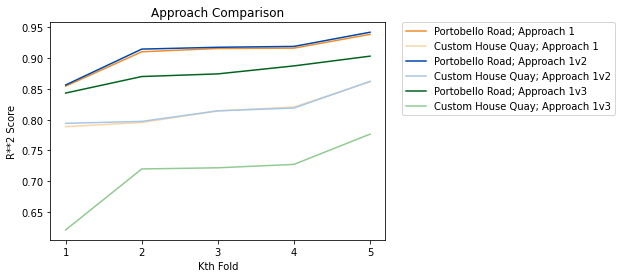

--------------------


In [25]:
# DRIVER

compare_approaches("PORTOBELLO ROAD", "CUSTOM HOUSE QUAY", run_approach1, run_approach1v2, run_approach1v3)
print("--------------------")